In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import softmax
import collections
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
import xgboost as xgb

from FairReg import FairReg
from evaluation import get_stats, get_risk_unf_wrt_eps
from evaluation_measures import DP_unfairness, prob_unfairness, prob_unfairness_summary, DP_unfairness_summary
from plots import plot_distributions_compare, plot_predictions_compare, plot_distributions, plot_predictions, plot_risk_history,plot_unfairness_history,plot_unfairness_vs_risk, plot_risk_unf_compare, plot_risk_unf_wrt_eps
from data_prep import get_lawschool_data, get_communities_data, get_frequencies

# Example 

Getting data

In [2]:
X, S, y = get_communities_data()

In [3]:
p = get_frequencies(S)

Splitting data into **train**, **unlab** and **test** groups

In [4]:
TRAIN_SIZE, UNLAB_SIZE, TEST_SIZE = 0.4, 0.4, 0.2

X_train, X_, S_train, S_, y_train, y_ = train_test_split(X, S, y, train_size = TRAIN_SIZE, stratify = S)
X_unlab, X_test, S_unlab, S_test, y_unlab, y_test = train_test_split(X_, S_, y_, test_size = TEST_SIZE/(1-TRAIN_SIZE), stratify = S_)

Training the **base (unfair) regression** method to predict **y** given **X**

In [5]:
reg = LinearRegression(fit_intercept=False)
reg.fit(X_train,y_train)

LinearRegression(fit_intercept=False)

Training a **classifier** to predict **S** given **X**

In [6]:
clf = LogisticRegression()
clf.fit(X_train, S_train)

LogisticRegression()

Training the **fair regression** to predict **y** given **X**

In [7]:
T=10000

fair_reg = FairReg(reg, clf, B=1, K=2,  p=p, eps=[0.00001, 0.00001], T=T, keep_history = False)
fair_reg.fit(X_unlab)

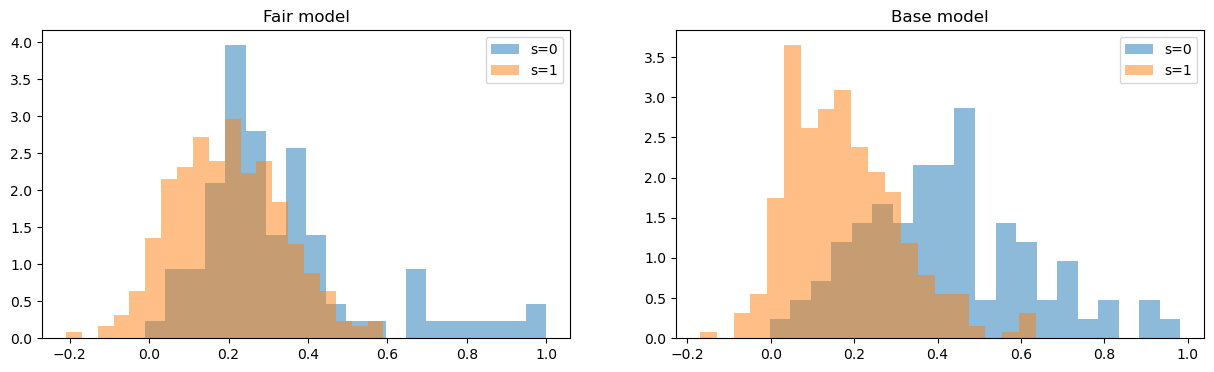

In [8]:
plot_distributions_compare(fair_reg, reg, X_test, S_test)

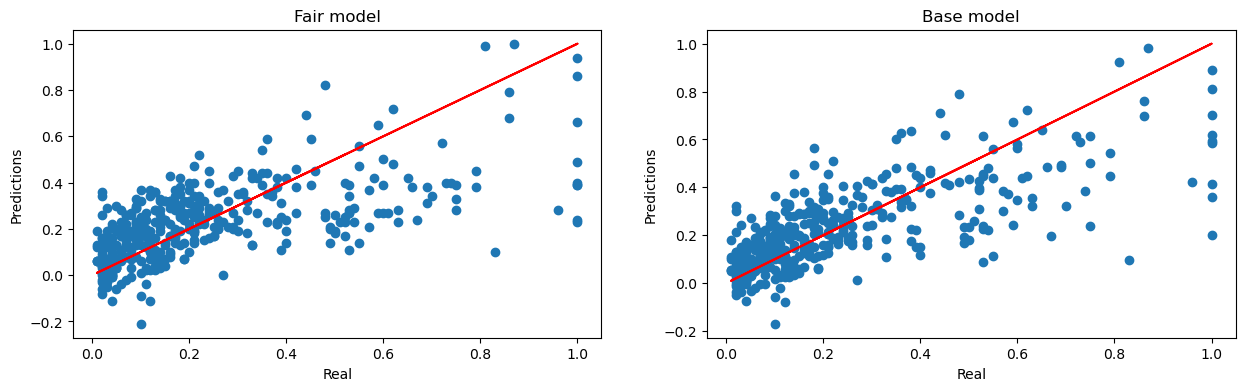

In [9]:
plot_predictions_compare(fair_reg, reg, X_test, y_test)

# Statistics: Risk vs Unfairness

### wrt number of iterations

In [14]:
T = 8000
num = 10
eps = [0.0001, 0.0001]

In [15]:
risk_history_all, max_unf_all, avg_unf_all, sum_unf_all, std_unf_all, DP_unf_all, base_risk_all, base_DP_all = get_stats(dataset='communities', 
            num=num, T=T, eps = eps, beta='auto', L='auto',
            TRAIN_SIZE=0.4, UNLAB_SIZE=0.4, TEST_SIZE=0.2)

1 / 10 : training...
training completed
retrieving training history...
training history retrieved and saved
2 / 10 : training...
training completed
retrieving training history...
training history retrieved and saved
3 / 10 : training...
training completed
retrieving training history...
training history retrieved and saved
4 / 10 : training...
training completed
retrieving training history...
training history retrieved and saved
5 / 10 : training...
training completed
retrieving training history...
training history retrieved and saved
6 / 10 : training...
training completed
retrieving training history...
training history retrieved and saved
7 / 10 : training...
training completed
retrieving training history...
training history retrieved and saved
8 / 10 : training...
training completed
retrieving training history...
training history retrieved and saved
9 / 10 : training...
training completed
retrieving training history...
training history retrieved and saved
10 / 10 : training...
traini

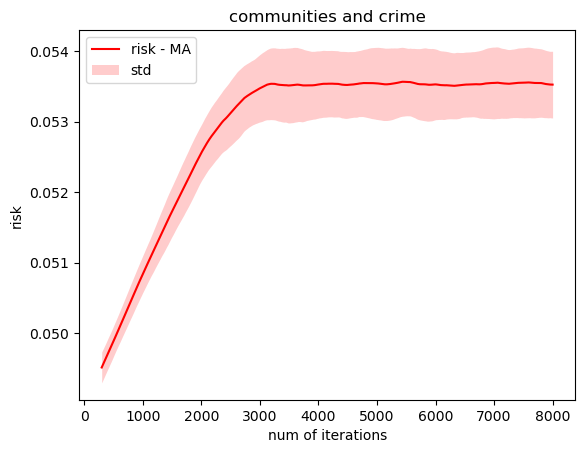

In [16]:
plot_risk_history(risk_history_all, T=T, moving_av=100, dataset = 'communities and crime')

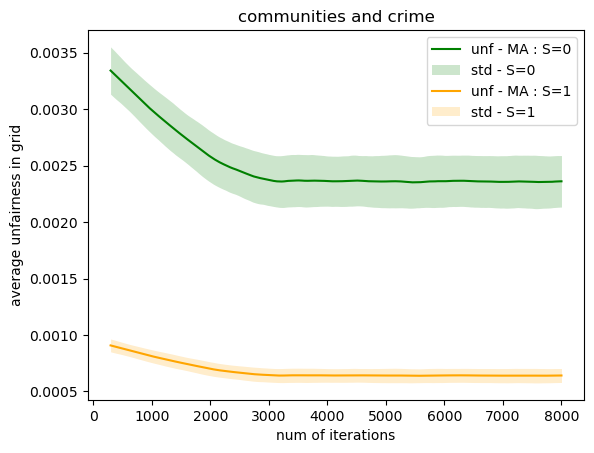

In [17]:
plot_unfairness_history(avg_unf_all, T=T, moving_av=100, K=2, dataset='communities and crime')

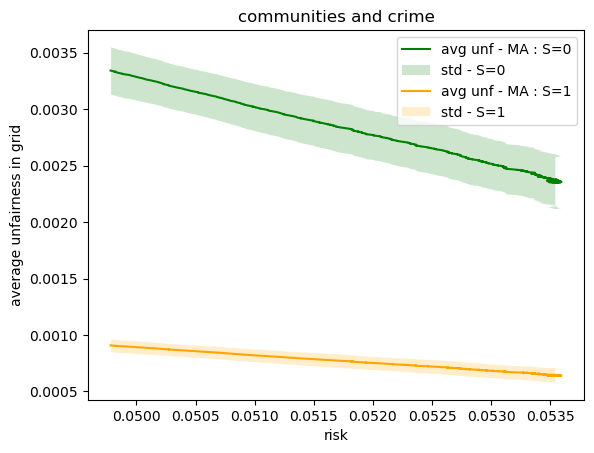

In [18]:
plot_unfairness_vs_risk(risk_history_all, avg_unf_all, T=T, moving_av=100, K=2, dataset='communities and crime')

_______________________________________________________

### wrt epsilon

In [19]:
num=10
T=3000

eps_list = []
for i in range (2,10):
    eps_list+=[[10**(-i), 10**(-i)]]

prob_risk_all, mse_risk_all, base_mse_risk, avg_all, DP_all, base_DP = get_risk_unf_wrt_eps(dataset='communities', 
            num=num, T=T, eps_list=eps_list, print_details = True, beta='auto', L='auto',
            TRAIN_SIZE=0.4, UNLAB_SIZE=0.4, TEST_SIZE=0.2)

1 / 8  : collecting statistics for eps=[0.01, 0.01]
-----    1 / 10 : training completed, statistics collected
-----    2 / 10 : training completed, statistics collected
-----    3 / 10 : training completed, statistics collected
-----    4 / 10 : training completed, statistics collected
-----    5 / 10 : training completed, statistics collected
-----    6 / 10 : training completed, statistics collected
-----    7 / 10 : training completed, statistics collected
-----    8 / 10 : training completed, statistics collected
-----    9 / 10 : training completed, statistics collected
-----    10 / 10 : training completed, statistics collected
---------------------------------------------------------
2 / 8  : collecting statistics for eps=[0.001, 0.001]
-----    1 / 10 : training completed, statistics collected
-----    2 / 10 : training completed, statistics collected
-----    3 / 10 : training completed, statistics collected
-----    4 / 10 : training completed, statistics collected
-----    

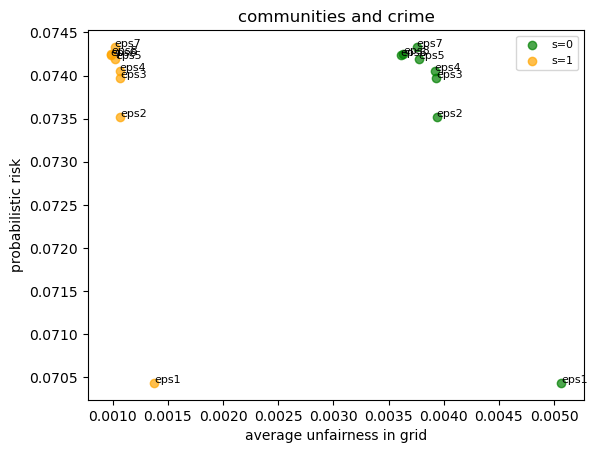

In [20]:
plot_risk_unf_wrt_eps(avg_all, prob_risk_all, K=2, unf_type='average unfairness in grid', 
                          risk_type='probabilistic risk', dataset='communities and crime',
                          colors = ['g', 'orange'], alpha=0.7)

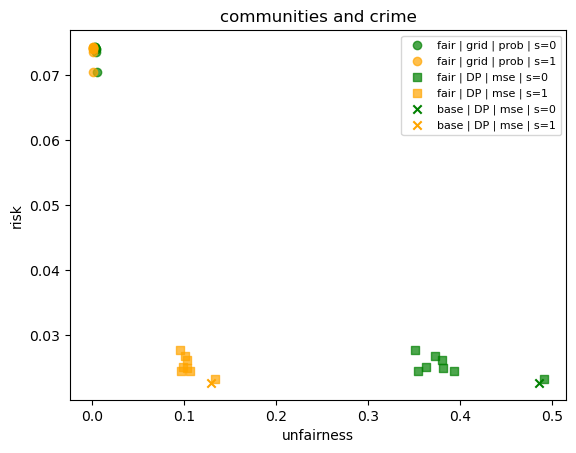

In [21]:
pairs_list = [[avg_all, prob_risk_all], [DP_all, mse_risk_all], [base_DP, base_mse_risk]]
model_list = ['fair', 'fair', 'base']
unf_type_list = ['grid', 'DP', 'DP']
risk_type_list = ['prob', 'mse', 'mse']
markers_list = ['o','s','x']

plot_risk_unf_compare(pairs_list=pairs_list, model_list=model_list, unf_type_list=unf_type_list, risk_type_list=risk_type_list, 
                      markers_list=markers_list, dataset='communities and crime',
                      x_label = 'unfairness', y_label = 'risk',
                      K=2, colors = ['g', 'orange'], alpha=0.7, annotate = False)